# Summary
||||||||||||||||||||||||||||||||||||||||

IEEE Computational Intelligence Society · Research Prediction

Fraud Detection

|||||||||||||||||||||||||||||||||||||||||

# Packages

In [2]:
!pip install  numba feature-engine ppscore


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\Nora\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
!pip install numba --upgrade

  Using cached numba-0.61.2-cp311-cp311-win_amd64.whl.metadata (2.9 kB)
Using cached numba-0.61.2-cp311-cp311-win_amd64.whl (2.8 MB)
  Attempting uninstall: numba
    Found existing installation: numba 0.61.0
    Uninstalling numba-0.61.0:


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'c:\\users\\nora\\appdata\\local\\packages\\pythonsoftwarefoundation.python.3.11_qbz5n2kfra8p0\\localcache\\local-packages\\python311\\site-packages\\numba\\tests\\test_refop_pruning.py'


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\Nora\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
from pathlib import Path
from feature_engine.selection import DropFeatures
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, spearmanr
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.graph_objects as go
import shap
from plotly.subplots import make_subplots
from ydata_profiling import ProfileReport
from yellowbrick.regressor import ResidualsPlot
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.stats import skew, kurtosis
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import fbeta_score
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.datasets import make_classification
import ppscore as pps

# Data

In [5]:
# Charger le chemin d'accès correspondant à votre machine 
HOME_DIR = r"C:\Users\HP\Desktop\LESLYE\ISEP2\S2\MACHINE_LEARNING\01-ieee-fraud-detection" #charger le chemin d'acces


In [ ]:
print(f"Work directory: {HOME_DIR} ")

In [ ]:
data = pd.read_csv(f"{HOME_DIR}/0_data/data_clean.csv")

# Modeling

## Catboost


In [6]:
y = data['isFraud']
X = data.drop('isFraud', axis=1)

In [7]:
cat_features = X.select_dtypes(include=['category']).columns.tolist()
cat_features

[]

In [8]:
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()


X[cat_features] = X[cat_features].astype(str)



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:

# Scoring F2
f2_scorer = make_scorer(fbeta_score, beta=2)

# Oversampler
smote = SMOTE(random_state=42)

# CatBoost
cat_model = CatBoostClassifier(
    random_state=42,
    verbose=0,
    eval_metric='AUC'
)

# Pipeline complet
pipe = Pipeline([
    ('smote', smote),
    ('clf', cat_model)
])

# Grille
param_grid = {
    'clf__iterations': [1000],
    'clf__depth': [4, 6],
    'clf__learning_rate': [0.1, 0.01],
}

# GridSearch
grid_search = GridSearchCV(
    pipe,
    param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=10,
    n_jobs=-1
)

# Entraînement
grid_search.fit(X_train, y_train)

# Résultats
print("Best params:", grid_search.best_params_)
print("Best AUC", grid_search.best_score_)

# Prédictions
y_pred = grid_search.predict(X_test)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [56]:
y_test = [int(y) for y in y_test]
y_pred = [int(y) for y in y_pred]


In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113866
           1       0.82      0.53      0.64      4242

    accuracy                           0.98    118108
   macro avg       0.90      0.76      0.81    118108
weighted avg       0.98      0.98      0.98    118108



In [58]:

y_pred_proba = grid_search.predict_proba(X_test)[:, 1]  # Pour les métriques basées sur les probabilités
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred_proba))
print("F1-Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

Accuracy: 0.9787821316083585
AUC: 0.9253943958196377
F1-Score: 0.6401493394600805
Precision: 0.8188831741366642
Recall: 0.5254596888260255


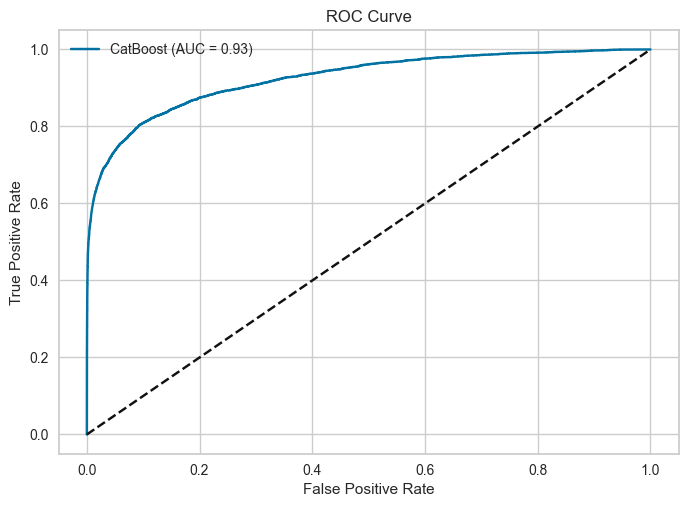

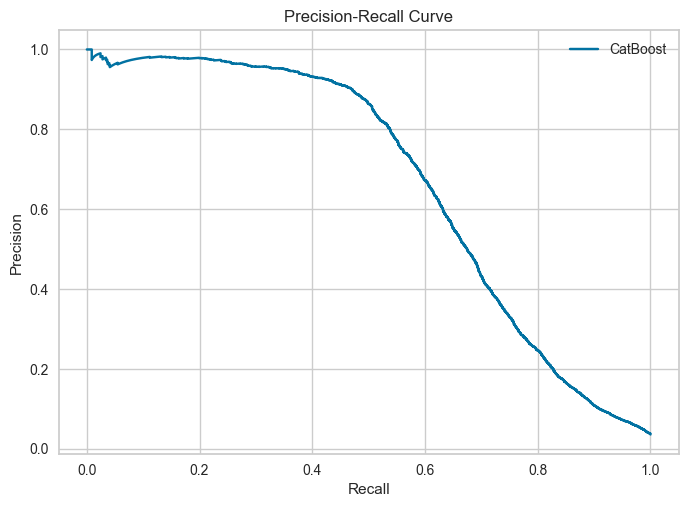

In [60]:

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='CatBoost (AUC = {:.2f})'.format(roc_auc_score(y_test, y_pred_proba)))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, label='CatBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

##### threshold pour maximiser le f2-score

In [62]:

def find_best_threshold_fbeta(y_true, y_proba, beta=2):
    best_threshold = 0.5
    best_score = 0

    thresholds = np.arange(0.01, 0.99, 0.01)

    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        score = fbeta_score(y_true, y_pred, beta=beta)

        if score > best_score:
            best_score = score
            best_threshold = threshold

    return best_threshold, best_score

# === EXEMPLE D'UTILISATION ===
best_thresh, best_fbeta = find_best_threshold_fbeta(y_test, y_proba, beta=2)
print(f"Best Threshold for F2: {best_thresh}, Best F2: {best_fbeta}")

Best Threshold for F2: 0.11, Best F2: 0.646375133594585


#### DECISION TREE

In [7]:
y = df_final['isFraud']
X = df_final.drop('isFraud', axis=1)

In [50]:

# Diviser les données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Oversampler
smote = SMOTE(random_state=42)

# Scoring F2
f2_scorer = make_scorer(fbeta_score, beta=2)

# Créer un pipeline avec preprocessing + modèle
pipeline = Pipeline([
    ('smote', smote),
    ('clf', DecisionTreeClassifier(random_state=42))
])

#  Définir la grille d'hyperparamètres
param_grid = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [3, 5, 10, None],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

# Grid search
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    scoring=f2_scorer, 
    n_jobs=-1,
    verbose=2  
)
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('clf',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__criterion': ['gini', 'entropy'],
                         'clf__max_depth': [3, 5, 10, None],
                         'clf__min_samples_leaf': [1, 2, 4],
                         'clf__min_samples_split': [2, 5, 10]},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
             verbose=2)

In [15]:

# Résultats
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated score:", grid_search.best_score_)

# Évaluation sur test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Best parameters: {'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2}
Best cross-validated score: 0.7911406362002963

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98    113866
         1.0       0.57      0.57      0.57      4242

    accuracy                           0.97    118108
   macro avg       0.78      0.78      0.78    118108
weighted avg       0.97      0.97      0.97    118108



In [22]:

score = fbeta_score(y_test, y_pred, beta=2)

print(f"Best F2: {score}")

Best F2: 0.5707289508381993


In [ ]:

y_pred_proba = grid_search.predict_proba(X_test)[:, 1]  # Pour les métriques basées sur les probabilités
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred_proba))
print("F1-Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

Accuracy: 0.9689944796288144
AUC: 0.8013902519461467
F1-Score: 0.5696827262044654
Precision: 0.5679475164011246
Recall: 0.5714285714285714


### XGBOOST

In [20]:
y = df_final['isFraud']
X = df_final.drop('isFraud', axis=1)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Pipeline : preprocessing + XGBoost
pipeline = Pipeline([
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# 4. Grille d’hyperparamètres
param_grid = {
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [3, 5, 7],
    'clf__learning_rate': [0.01, 0.1, 0.3],
    'clf__subsample': [1.0],
    'clf__colsample_bytree': [0.8, 1.0],
    'clf__scale_pos_weight': [20, 30, 40]
}
f2_scorer = make_scorer(fbeta_score, beta=2, average='binary')
# 5. GridSearch
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring=f2_scorer,
    n_jobs=-1,
    verbose=2
)

# 6. Entraînement
grid_search.fit(X_train, y_train)




Fitting 5 folds for each of 108 candidates, totalling 540 fits


C:\Users\Nora\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [10:06:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='logloss',
                                                      feature_types=None,
                                                      feature_weights=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=None...
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'clf__colsample_bytree': [0.8, 1.0],
                         'clf__learning_rate': [0.01, 0.1, 0.3],
                         'clf__max_depth': [3, 5, 7],
                         'clf__n_estimators': [50, 100],
                         'clf__scale_pos_weight': [20, 30, 40],
                         'clf__subsample': [1.0]},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2, average=binary),
             verbose=2)

In [23]:
# 7. Résultats
print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validated score:", grid_search.best_score_)

# 8. Évaluation sur test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Best parameters: {'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.3, 'clf__max_depth': 7, 'clf__n_estimators': 100, 'clf__scale_pos_weight': 20, 'clf__subsample': 1.0}
Best cross-validated score: 0.9464562130309

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.95      0.97    113866
         1.0       0.38      0.80      0.52      4242

    accuracy                           0.95    118108
   macro avg       0.69      0.88      0.75    118108
weighted avg       0.97      0.95      0.96    118108



In [25]:
score = fbeta_score(y_test, y_pred, beta=2)

print(f"Best F2: {score}")

Best F2: 0.6579457364341085


In [24]:

y_pred_proba = grid_search.predict_proba(X_test)[:, 1]  # Pour les métriques basées sur les probabilités
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred_proba))
print("F1-Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

Accuracy: 0.9467944593084295
AUC: 0.9529989397613892
F1-Score: 0.5193513844271073
Precision: 0.38439764492753625
Recall: 0.8003300330033003


#### XGBOOST  with SMOTE

In [30]:
y = df_final['isFraud']
X = df_final.drop('isFraud', axis=1)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Oversampler
smote = SMOTE(random_state=42)

# Scoring F2
f2_scorer = make_scorer(fbeta_score, beta=2)

# Créer un pipeline avec preprocessing + modèle
pipeline = Pipeline([
    ('smote', smote),
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# 4. Grille d’hyperparamètres
param_grid = {
    'smote__sampling_strategy': [0.1, 0.2, 0.3],
    'smote__k_neighbors': [7],
    'clf__colsample_bytree': [1.0],
    'clf__learning_rate': [0.3],
    'clf__max_depth': [7],
    'clf__n_estimators': [100],
    'clf__scale_pos_weight': [20],
    'clf__subsample': [1.0]
}

f2_scorer = make_scorer(fbeta_score, beta=2, average='binary')
# 5. GridSearch
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

# 6. Entraînement
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Nora\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [04:55:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='logloss',
                                                      feature_types=None,
                                                      feature_weights=None,
                                                      gamma=None,
                                                      grow...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'clf__colsample_bytree': [1.0],
                         'clf__learning_rate': [0.3], 'clf__max_depth': [7],
                         'clf__n_estimators': [100],
                         'clf__scale_pos_weight': [20], 'clf__subsample': [1.0],
                         'smote__k_neighbors': [7],
                         'smote__sampling_strategy': [0.1]},
             scoring='roc_auc', verbose=2)

In [32]:
# 7. Résultats
print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validated score:", grid_search.best_score_)

# 8. Évaluation sur test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Best parameters: {'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.3, 'clf__max_depth': 7, 'clf__n_estimators': 100, 'clf__scale_pos_weight': 20, 'clf__subsample': 1.0, 'smote__k_neighbors': 7, 'smote__sampling_strategy': 0.1}
Best cross-validated score: 0.9442018958334053

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.94      0.97    113866
         1.0       0.34      0.81      0.48      4242

    accuracy                           0.94    118108
   macro avg       0.67      0.87      0.72    118108
weighted avg       0.97      0.94      0.95    118108



In [34]:
score = fbeta_score(y_test, y_pred, beta=2)

print(f"Best F2: {score}")

Best F2: 0.634761639769987


In [33]:
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]  # Pour les métriques basées sur les probabilités
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred_proba))
print("F1-Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

Accuracy: 0.9374724828123413
AUC: 0.9485474638282358
F1-Score: 0.4809895284278586
Precision: 0.34264543907079203
Recall: 0.8066949552098067
